In [ ]:
%load_ext autoreload
%autoreload 2

# Analytical solution: scan over initial copynumber for different peaks

In this notebook, we consolidate the analytical solution derived in notebook `27_sensitivity_peak3` into functions. We then use these functions to scan over the likely peaks in sensitivity and precision across different starting copynumbers.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
from scipy.optimize import root, least_squares
import importlib, warnings
import sympy as sp
from common import set_theme
import os

set_theme(style='whitegrid')


from synbio_morpher.utils.modelling.physical import gibbs_K, equilibrium_constant_reparameterisation

top_write_dir = os.path.join('data', '29_sensitivity_peak5')
os.makedirs(top_write_dir, exist_ok=True)

### Define scan parameters

In [ ]:
scan_params = {
    'n_species': [2, 3, 4, 5, 6, 7, 10, 20, 30, 50, 100, 200, 400, 600, 1000],
    'starting_copynumbers': [1, 2, 5, 10, 50, 100, 500, 1000, 1e4],
    'signal_perturb_mult': [0.1, 0.5, 1, 2, 5, 10, 100]
}

n = scan_params['n_species']
xinit = scan_params['starting_copynumbers']
s = scan_params['signal_perturb_mult']
k_a = 1e6  # 1/(M*s)

K = equilibrium_constant_reparameterisation(0, initial=200)

### Functions for analytical solution

Finding steady states as roots of perturbed system 


For i = range(n - 1) | i!=1, j = range(n - 1) | j>=i:

$y_{11} = K a^2$ <------ * 1

$y_{1i} = K ab$  <------ * (n - 1)

$y_{ij} = K b^2$ <------ * n*(n - 1)/2

Derivation for $y_{ij}$ amounts:
- n_paired_species - $y_{1i}$ - $y_{11}$
- $(n * (n+1)/2) - n$
- $(n * (n + 1) - 2*n)/2$
- $(n^2 + n - 2*n)/2$
- $(n^2 - n)/2$
- $n*(n - 1)/2$


This then changes the conservation equations to the following for the signal species $RNA_1$:

$a + 2 K a^2 + (n - 1) K ab = s c_1 + (n + 1) K c_1^2$

$b + n*(n - 1)/2 K b^2 + K ab = c_1 + (n + 1) K c_1^2$

We can use python packages that handle such polynomial system calculations such as `sympy` for finding $a$ and $b$, given that we know $K$ and $c_1$ already.



In [ ]:
# helpers
def get_kd(k_a, K):
    return k_a / K


def calc_n_paired_species(n):
    ''' Rearranged from n*n - ((n * n - n) / 2) '''
    return n * (n+1)/2


Derivation of steady states for analytical solution before perturbation

$x + (n+1) K x^2 = c_0$ --------> $x = \frac{-1 ± \sqrt{1 - 4((n+1)K)(-c_0)}}{2((n+1)K)}$

In [ ]:
def calc_x_pre(c_0, K, n):
    """ Analytical steady states solution when all RNA species start 
    with the same copynumber c_0."""
    top = jnp.sqrt(1 - 4 * (n+1) * K * (-c_0))
    denom = 2 * (n+1) * K

    x_plus = jnp.divide(-1 + top, denom)
    x_minus = jnp.divide(-1 - top, denom)

    return x_plus, x_minus

In [ ]:
def calc_steady_states_perturbed(n, c_1, K, s, method='least_squares'):
    """ Analytical steady states solution when one RNA species starts 
    with copynumber s*c_1 and the rest with c_1.
    Returns [a, b] using 4 different attempted methods. """

    def F(vars):
        a, b = vars
        f1 = a + 2*K*a**2 + (n - 1)*K*a*b - s*c_1 - (n + 1)*K*c_1**2
        f2 = b + (n*(n - 1)/2)*K*b**2 + K*a*b - c_1 - (n + 1)*K*c_1**2
        return np.array([f1, f2])

    def elimination_method(K, c_1):
        roots_from_elim = None
        a_sym, b_sym, K_sym, c1_sym = sp.symbols('a b K c_1')
        f1_sym = a_sym + 2*K_sym*a_sym**2 + \
            (n - 1)*K_sym*a_sym*b_sym - c1_sym - (n + 1)*K_sym*c1_sym**2
        f2_sym = b_sym + (n*(n - 1)/2)*K_sym*b_sym**2 + K_sym * \
            a_sym*b_sym - c1_sym - (n + 1)*K_sym*c1_sym**2
        poly_b = sp.resultant(f1_sym, f2_sym, a_sym)
        poly_b_num = sp.expand(poly_b.subs({K_sym: K, c1_sym: c_1}))
        coeffs = sp.Poly(poly_b_num, b_sym).all_coeffs()
        coeffs = np.array([np.float64(cc) for cc in coeffs], dtype=np.float64)
        roots_b = np.roots(coeffs).astype(np.float64)
        a_from_b = []
        for rb in roots_b:
            if abs(rb) > 1e-13:
                a_val = (c_1 + 4*K*c_1**2 - rb - 3*K*rb**2) / (K * rb)
            else:
                a_val = np.nan
            a_from_b.append(a_val)
        roots_from_elim = np.column_stack(
            [np.array(a_from_b, dtype=np.float64), roots_b])
        return roots_from_elim

    roots_ab_alt = np.ones((4), dtype=np.float64) * np.nan
    initial_guess = np.array([s*c_1, c_1], dtype=np.float64)

    # 1) scipy.optimize.root
    if method == 'hybr':
        sol_root = root(F, initial_guess, method='hybr')
        if sol_root.success:
            roots_ab_alt[:2] = sol_root.x
            return roots_ab_alt

    elif method == 'lm':
        sol_root_lm = root(F, initial_guess, method='lm')
        if sol_root_lm.success:
            roots_ab_alt[:2] = sol_root_lm.x
            return roots_ab_alt

    # 2) least_squares with positivity bounds
    elif method == 'least_squares':
        sol_ls = least_squares(F, initial_guess, bounds=(0, np.inf))
        if sol_ls.success:
            roots_ab_alt[:2] = sol_ls.x
            return roots_ab_alt
    elif method == 'elimination':
        # 3) Elimination -> polynomial in b (requires sympy)
        try:
            roots = elimination_method(K, c_1)
            pos_roots = [(ra, rb)
                         for ra, rb in roots if (ra >= 0) and (rb >= 0)]
            if len(pos_roots) == 1:
                # print("Elimination method found positive roots:", pos_roots)
                roots_ab_alt[:2] = pos_roots[0]
                return roots_ab_alt
            elif len(pos_roots) > 1:
                print(
                    f'Warning: found multiple possible roots {pos_roots}. Returning both pairs.')
                roots_ab_alt[:2] = pos_roots[0]
                roots_ab_alt[2:] = pos_roots[1]
                return roots_ab_alt
        except:
            print(f'Elimination method failed on n={n}, c_1={c_1}, K={K}.')
    else:
        raise ValueError(f'Unknown method {method}.')
    raise ValueError("No root-finding method succeeded.")

## Scan loop

In [ ]:
from itertools import product

scan_combinations = np.array(list(product(
    scan_params['n_species'], 
    scan_params['starting_copynumbers'], 
    scan_params['signal_perturb_mult'])))

In [ ]:
from tqdm.notebook import tqdm

init_steady_states = np.ones((len(scan_combinations), 1)) * np.nan
steady_states = np.ones((len(scan_combinations), 2)) * np.nan
steady_states_alt = np.ones((len(scan_combinations), 2)) * np.nan
for i, (n, xinit, s) in enumerate(tqdm(scan_combinations, desc="Scanning combinations")):

    K = equilibrium_constant_reparameterisation(0, initial=xinit)

    xplus, xminus = calc_x_pre(xinit, K, n)
    c_1 = max(xplus, xminus)
    assert c_1 > 0, "$c_1$ must be positive"

    roots = calc_steady_states_perturbed(n, c_1, K, s)
    xsteady_a, xsteady_b = roots[:2]
    assert xsteady_a >= 0 and xsteady_b >= 0, "Steady states must be positive"

    init_steady_states[i] = c_1
    steady_states[i, 0] = xsteady_a
    steady_states[i, 1] = xsteady_b
    steady_states_alt[i] = roots[2:]

Scanning combinations:   0%|          | 0/945 [00:00<?, ?it/s]

In [ ]:
results = pd.DataFrame(columns=[
    '$c_1$', '$[RNA_1]$', '$[RNA_{out}]$',
    '$[RNA_1]$ alternative', '$[RNA_{out}]$ alternative',
    'N species', '$c_0$', 'Perturbation Multiplier'],
    data=np.column_stack([
        init_steady_states.flatten(),
        steady_states[:, 0],
        steady_states[:, 1],
        steady_states_alt[:, 0],
        steady_states_alt[:, 1],
        scan_combinations]))
results.loc[results['$[RNA_1]$ alternative'].isna(), '$[RNA_1]$ alternative'] = results['$[RNA_1]$']
results.loc[results['$[RNA_{out}]$ alternative'].isna(), '$[RNA_{out}]$ alternative'] = results['$[RNA_{out}]$']
# assert (results['$[RNA_1]$ alternative'] != results['$[RNA_1]$']).sum() > 0, 'Alternative were probably overwritten'

# Calculate sensitivity & precision

In [ ]:
O_1 = results['$c_1$'].values
I_1 = results['$c_1$'].values * results['Perturbation Multiplier'].values
O_2 = O_peak = results['$[RNA_{out}]$'].values
I_2 = results['$[RNA_1]$'].values

results['sensitivity'] = np.abs(np.divide(
    np.divide(O_peak - O_1, O_1),
    np.divide(I_2 - I_1, I_1)
))
results['precision'] = 1 / np.abs(np.divide(
    np.divide(O_2 - O_1, O_1),
    np.divide(I_2 - I_1, I_1)
))
results[(results['N species'] == 3) & (results['Perturbation Multiplier'] == 2)]['sensitivity']
results[(results['N species'] == 3) & (results['Perturbation Multiplier'] == 2) &
        (results['$c_0$'] == 100)]['$[RNA_1]$']


/tmp/ipykernel_1489647/926835299.py:8: RuntimeWarning: invalid value encountered in divide
  results['sensitivity'] = np.abs(np.divide(
/tmp/ipykernel_1489647/926835299.py:12: RuntimeWarning: invalid value encountered in divide
  results['precision'] = 1 / np.abs(np.divide(


101    199.462224
Name: $[RNA_1]$, dtype: float64

# Plot results

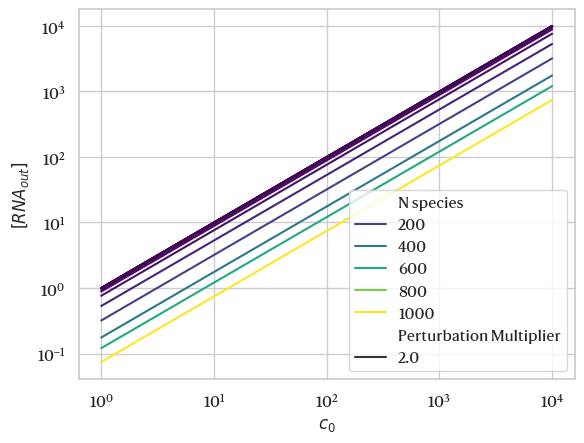

In [ ]:
filt = results['Perturbation Multiplier'] == 2
sns.lineplot(results[filt],
             x='$c_0$', y='$[RNA_{out}]$', hue='N species', style='Perturbation Multiplier',
             palette='viridis')
plt.xscale('log')
plt.yscale('log')

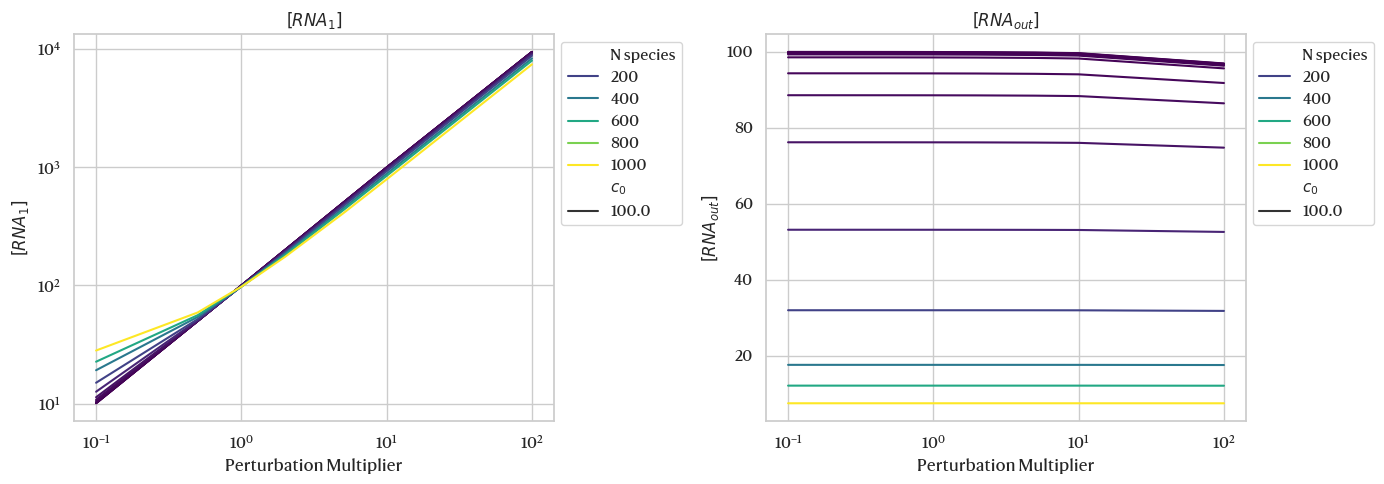

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
filt = results['$c_0$'] == 100
g = sns.lineplot(results[filt],
             x='Perturbation Multiplier', y='$[RNA_1]$', hue='N species', style='$c_0$',
             palette='viridis', ax=axs[0])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
axs[0].set_title('$[RNA_1]$')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
g = sns.lineplot(results[filt],
             x='Perturbation Multiplier', y='$[RNA_{out}]$', hue='N species', style='$c_0$',
             palette='viridis', ax=axs[1])
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
axs[1].set_title('$[RNA_{out}]$')
axs[1].set_xscale('log')
# plt.yscale('log')
plt.tight_layout()

Text(0.5, 1.0, '$[RNA_{out}]$ for n=100 species')

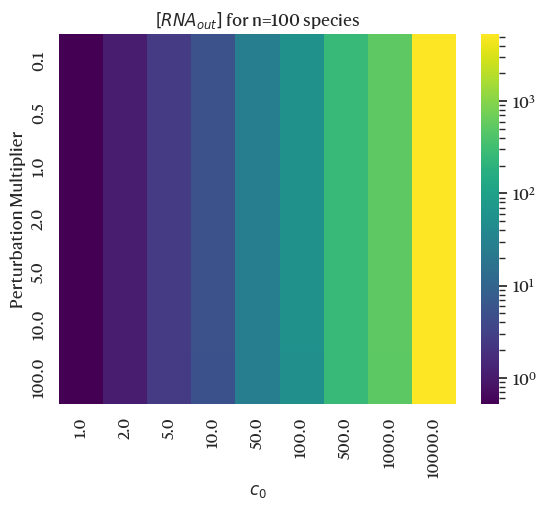

In [ ]:
from matplotlib.colors import LogNorm


filt = results['N species'] == 100
sns.heatmap(results[filt].pivot(index='Perturbation Multiplier', columns='$c_0$', 
                                values='$[RNA_{out}]$'), cmap='viridis',
            norm=LogNorm())
plt.title('$[RNA_{out}]$ for n=100 species')

Text(0.5, 1.0, '$[RNA_{out}]$ fold change for $c_0$=100')

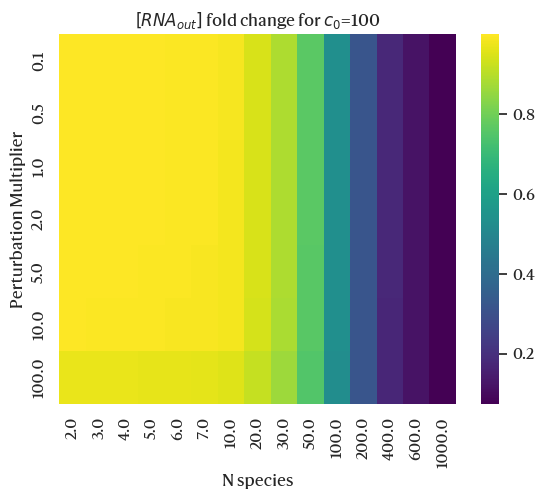

In [ ]:
from matplotlib.colors import LogNorm


filt = results['$c_0$'] == 100
results['$[RNA_{out}]$ fold change'] = results['$[RNA_{out}]$'] / results['$c_0$']
sns.heatmap(results[filt].pivot(index='Perturbation Multiplier', columns='N species', 
                                values='$[RNA_{out}]$ fold change'), cmap='viridis')
            # norm=LogNorm())
plt.title('$[RNA_{out}]$ fold change for $c_0$=100')

In [ ]:
results['$c_0$'].unique()

array([1.e+00, 2.e+00, 5.e+00, 1.e+01, 5.e+01, 1.e+02, 5.e+02, 1.e+03,
       1.e+04])

Text(0.5, 1.0, 'Precision for signal multiplier = 2')

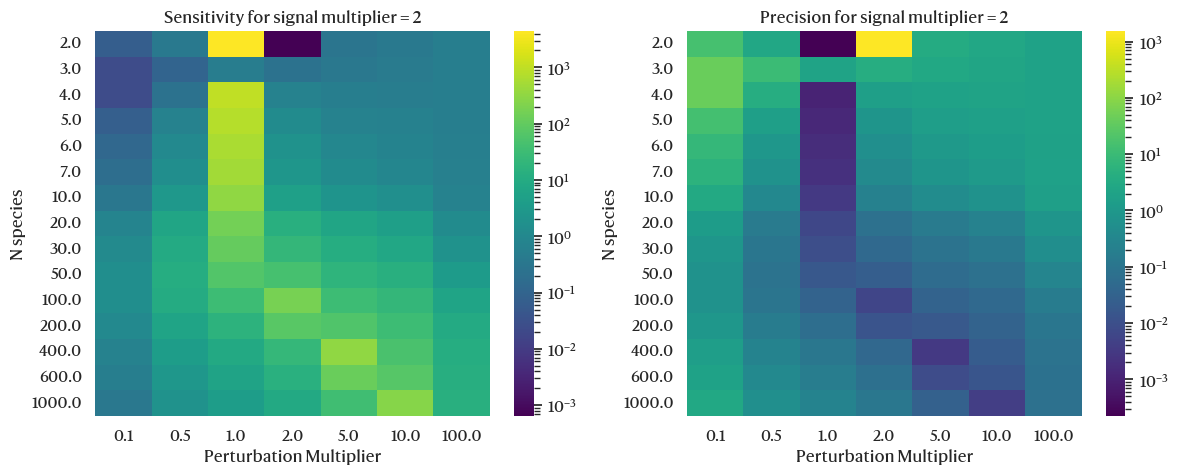

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
s = 2
filt = results['$c_0$'] == 10000
val = 'sensitivity'
sns.heatmap(results[filt].pivot(index='N species', columns='Perturbation Multiplier', 
                                values=val), cmap='viridis',
            norm=LogNorm(), ax=axs[0])
axs[0].set_title(f'{val.capitalize()} for signal multiplier = {s}')
val = 'precision'
sns.heatmap(results[filt].pivot(index='N species', columns='Perturbation Multiplier', 
                                values=val), cmap='viridis',
            norm=LogNorm(), ax=axs[1])
axs[1].set_title(f'{val.capitalize()} for signal multiplier = {s}')